In [1]:
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as sns

In [2]:
path = "../data/ex2data1.txt"  
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


2D visualisation

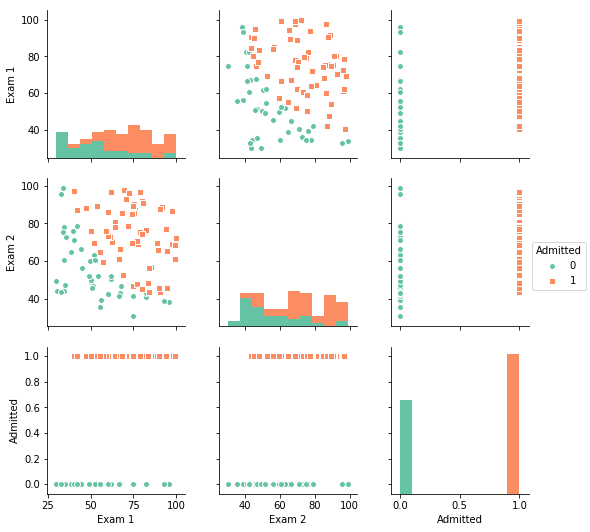

In [3]:
sns.pairplot(data, kind="scatter", hue="Admitted", markers=["o", "s"], palette="Set2")


# Logistic regression:

Logistic regression applies the sigmoid function to the linear regresion representation:

![alt text](LogReg_1.png "Title")


treat the data to define the linear model:

In [4]:
data.insert(0, 'Ones', 1)

In [5]:
cols = data.shape[1]  
X = data[['Ones','Exam 1','Exam 2']]
y = data[['Admitted']]
X = np.matrix(X.values)  
y = np.matrix(y.values) 

In [6]:
theta = np.matrix(np.array([0,0,0]))  

define the sigmoid function:

In [7]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

# Cost function:

The logistic regression cost function is defined in the folowing way (same style as a ML estimation):

![alt text](lecture6-logistic-regression_slide19.png "Title")



In [8]:
def computeCost(theta,X, y):
    theta = np.matrix(theta)
    h_theta = sigmoid(X * theta.T)
    inner = np.multiply(y, np.log(h_theta)) + np.multiply(1-y, np.log(1-h_theta)) 
    return np.sum(inner) / (-len(X))


With our parameters initialised at 0, this is :

In [9]:
computeCost(theta,X, y)  


0.6931471805599453

# Gradient descent to optimise parameters:

The gradient descent comes out to be equivalent to the one from linear regresion:

![alt text](v4iYn.png "Title")



In [10]:
def gradientDescent(X, y, theta, alpha, iters):  
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(iters)
    

    for i in range(iters):
        h_theta = sigmoid(X * theta.T)

        error = h_theta-y

        for j in range(parameters):
            # term is 1 for theta0 and x1 for theta1, and is multiplied in vectorial from to the error computed before
            term = np.multiply(error, X[:,j])
            
            #this is the formula seen in the previous cell
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))

        theta = temp
        #compute cost after each iteration
        cost[i] = computeCost(theta,X, y)

    return theta, cost

In [11]:
alpha = 0.001  
iters = 100000

# perform gradient descent to "fit" the model parameters
g, cost = gradientDescent(X, y, theta, alpha, iters) 

g, cost

(matrix([[-4.81180027,  0.04528064,  0.03819149]]),
 array([0.69829069, 0.65971176, 0.66162727, ..., 0.38739176, 0.38739064,
        0.38738952]))

Accuracy based on the minimised theta parameter values and the target:

In [12]:
def predict(theta, X):  
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

predictions = predict(g, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print 'accuracy = {0}%'.format(accuracy) 

accuracy = 91%


use an external minimisation procedure, based on the computed gradient and the cost functions:
    

In [13]:
def gradient(theta,X, y): 
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    return grad

In [14]:
import scipy.optimize as opt  
result = opt.fmin_tnc(func=computeCost, x0=np.zeros(3), fprime=gradient, args=(X, y))  
result

(array([-25.16131861,   0.20623159,   0.20147149]), 36, 0)

In [15]:
theta_min = np.matrix(result[0])  
predictions = predict(theta_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print 'accuracy = {0}%'.format(accuracy)  

accuracy = 89%


# Regularisation:
Regularization is a term in the cost function that causes the algorithm to prefer "simpler" models (in this case, models will smaller coefficients). The theory is that this helps to minimize overfitting and improve the model's ability to generalize. 

In [16]:
path = "../data/ex2data2"  
data2 = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data2.head()

,Exam 1,Exam 2,Admitted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


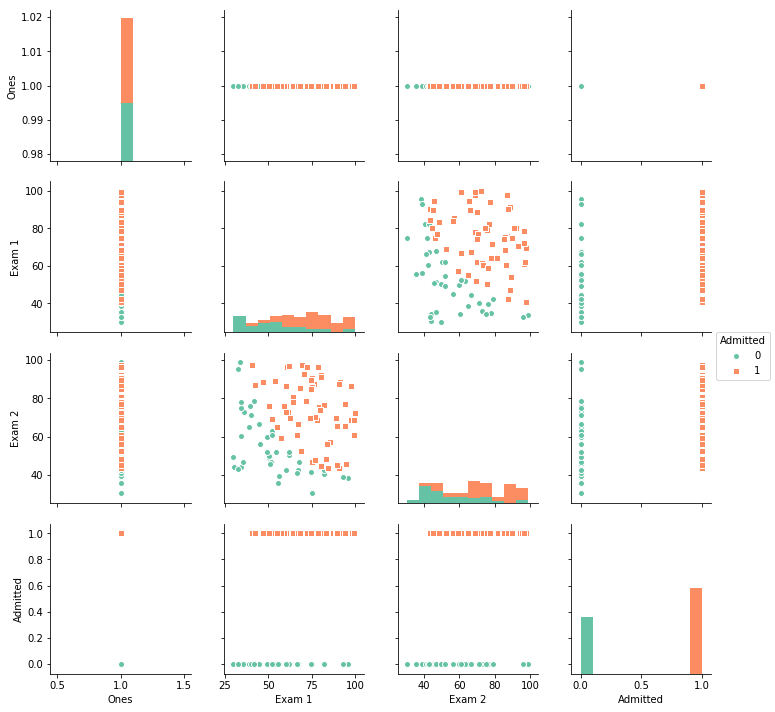

In [17]:
sns.pairplot(data, kind="scatter", hue="Admitted", markers=["o", "s"], palette="Set2")


# Regularised cost function:

![alt text](regularised.png "Title")


In [18]:
def computeCostReg(theta,X, y,learningRate):
    theta = np.matrix(theta)
    h_theta = sigmoid(X * theta.T)
    inner = np.multiply(y, np.log(h_theta)) + np.multiply(1-y, np.log(1-h_theta)) 
    reg = learningRate/(2*len(X))*np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(inner) / (-len(X)) + reg


# Regularised gradient:

![alt text](rg402.png "Title")



In [19]:
def gradientReg(theta,X, y,learningRate): 
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if i !=0:
            grad[i] = np.sum(term) / len(X) + ((learningRate / len(X)) * theta[:,i])
        else:
            grad[i] = np.sum(term) / len(X)
            
    return grad


In [20]:
data2.insert(3, 'Ones', 1)

In [21]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  
X2 = data2.iloc[:,1:cols]  
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(3)

learningRate = 1

computeCostReg(theta2, X2, y2, learningRate)  

0.6931471805599455

In [22]:
learningRate =1
result = opt.fmin_tnc(func=computeCostReg, x0=np.zeros(3), fprime=gradientReg, args=(X2, y2,learningRate))  


In [23]:
theta_min = np.matrix(result[0])  
predictions = predict(theta_min, X2)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print 'accuracy = {0}%'.format(accuracy) 

accuracy = 40%


# Improve result by adding complexity to the features:

The data looks more complicated than the previous example. There is no linear decision boundary that will perform well on this data. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. We can try creating a bunch of polynomial features to feed into the classifier.

In [24]:
degree = 5  
x1 = data2['Exam 1']  
x2 = data2['Exam 2']

for i in range(1, degree):  
    for j in range(0, i):
        data2['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Exam 1', axis=1, inplace=True)  
data2.drop('Exam 2', axis=1, inplace=True)

data2.head()  

,Admitted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


In [25]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]  
X2 = data2.iloc[:,1:cols]  
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(11)

learningRate = 1

In [37]:
learningRate =2
result_complex = opt.fmin_tnc(func=computeCostReg, x0=theta2, fprime=gradientReg, args=(X2, y2,learningRate)) 
theta_min = np.matrix(result_complex[0])  
predictions = predict(theta_min, X2)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print 'accuracy = {0}%'.format(accuracy) 




accuracy = 50%


SOMETHING IS WRONG HERE, NEED TO CHECK